# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# 1 - Importing modules

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [4]:
data_folder = "../../Dataset/Movie/"

In [15]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId")

# 3 - Transforming data

In [16]:
#Séparation en ligne du dataframe en petits dataframe
N = 1000
data_list = []
L = data.shape[0]

for i in range(1,N+1):
    debut = int((i-1)*L/N)
    fin = int(i*L/N)
    data_list.append(data.iloc[debut:fin, :])

In [17]:
#pivot table de chaque petits dataframe
pv_list = []
N = len(data_list)

i = 0
for d in tqdm(data_list):
    pv_list.append(d.pivot_table(index="userId", columns="title", values="rating", dropna=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
#Réunir tous les pivots tables selon le film
titles = data.title.unique()
dico = {title : [] for title in titles}

for pv in pv_list:
    for title in pv:
        dico[title].append(pv[title])

In [19]:
#Concatener tous les pivots tables selon leur film et on les gardes uniquement si ils ont pas trop d'éléments manquant.
all_df = []
keep_title = []
thresh = 0.3

i = 0
for title in tqdm(titles):
    tmp = pd.concat(dico[title], axis=0)
    if not (np.sum(tmp.isna(), axis=0) > tmp.shape[0]*thresh):
        all_df.append(tmp)
        keep_title.append(title)

  0%|          | 0/58958 [00:00<?, ?it/s]

In [ ]:
#On met tous les données dans un seul dataframe
userId_title_df = pd.DataFrame(index=np.sort(data.userId.unique()), columns=keep_title)

for df in tqdm(all_df):
    index = df.index
    values = df.values
    title = df.name

    for i in range(len(index)):
        userId_title_df.iloc[index[i]-1][title] = values[i]

userId_title_df.to_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [22]:
del(userId_title_df)
#Si la dataframe a déjà été exporté, on peut le récupérer localement
if not ("userId_title_df" in locals()):
    userId_title_df = pd.read_csv(f"{data_folder}userId_title_df.csv", sep=";")

#On supprime les utilisateurs qui n'ont pas assez donnés de notes
userId_title_df = userId_title_df.dropna(axis=0, thresh=60).drop(userId_title_df.columns[0], axis=1)

# 4 - Colaborative filtering

In [24]:
#Standardisation des lignes pour supprimer les biais
def standardize(row):
    return row - np.mean(row)

userId_title_std = userId_title_df.apply(standardize, axis=1).fillna(0)
userId_title_std.shape

(10013, 131)

In [74]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(userId_title_std)

In [26]:
#On garde les candidats similaire et complétement opposé
eps = 0.8
L = len(cos)
cluster = []

for i in tqdm(range(L)):
    cluster.append({"+" : [], "-" : []})
    for j in range(i+1, L):
        tmp = cos[i,j]
        if (tmp >= eps):
            cluster[i]["+"].append(j)
        elif (tmp <= -eps):
            cluster[i]["-"].append(j)

  0%|          | 0/10013 [00:00<?, ?it/s]

In [60]:
#On devine la note en fonction des candidtats similaires
def guess_rate_cluster(user, title):
    if (len(cluster[user]["+"]) == 0):
        return 2.5
    else:
        rate = 0
        coeff = 0

        for u in cluster[user]["+"]:
            if not (pd.isnull(userId_title_df.iloc[u][title])):
                rate += cos[user, u]*userId_title_df.iloc[u][title]
                coeff += cos[user, u]

        if (coeff == 0):
            return 2.5
        else:   
            return rate/coeff

In [61]:
#On devine la note en fonction de tous les candidats
def guess_rate_all(user, title):
    L = len(cos)
    rate = 0
    coef = 0

    for i in range(L):
        if (i != user) and not (pd.isnull(userId_title_df.iloc[i][title])):
            rate += cos[user, i]*userId_title_df.iloc[i][title]
            coef += cos[user, i]

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [69]:
#On compare les deux méthodes
from time import time

user = 12
titles = userId_title_df.columns

deltaT = []
t_cluster = []
t_all = []
positif = 0

deltaN = []
n_cluster = []
n_all = []
sup = 0

for title in tqdm(titles):
    start = time()
    n_cluster.append(guess_rate_cluster(user, title))
    t_cluster.append(time() - start)

    start = time()
    n_all.append(guess_rate_all(user, title))
    t_all.append(time() - start)
    
    dN = n_cluster[-1]-n_all[-1]
    deltaN.append(np.abs(dN))
    sup += 1 if (dN > 0) else 0 

    dT = t_all[-1]-t_cluster[-1]
    deltaT.append(np.abs(dT))
    positif += 1 if (dT > 0) else 0

  0%|          | 0/131 [00:00<?, ?it/s]

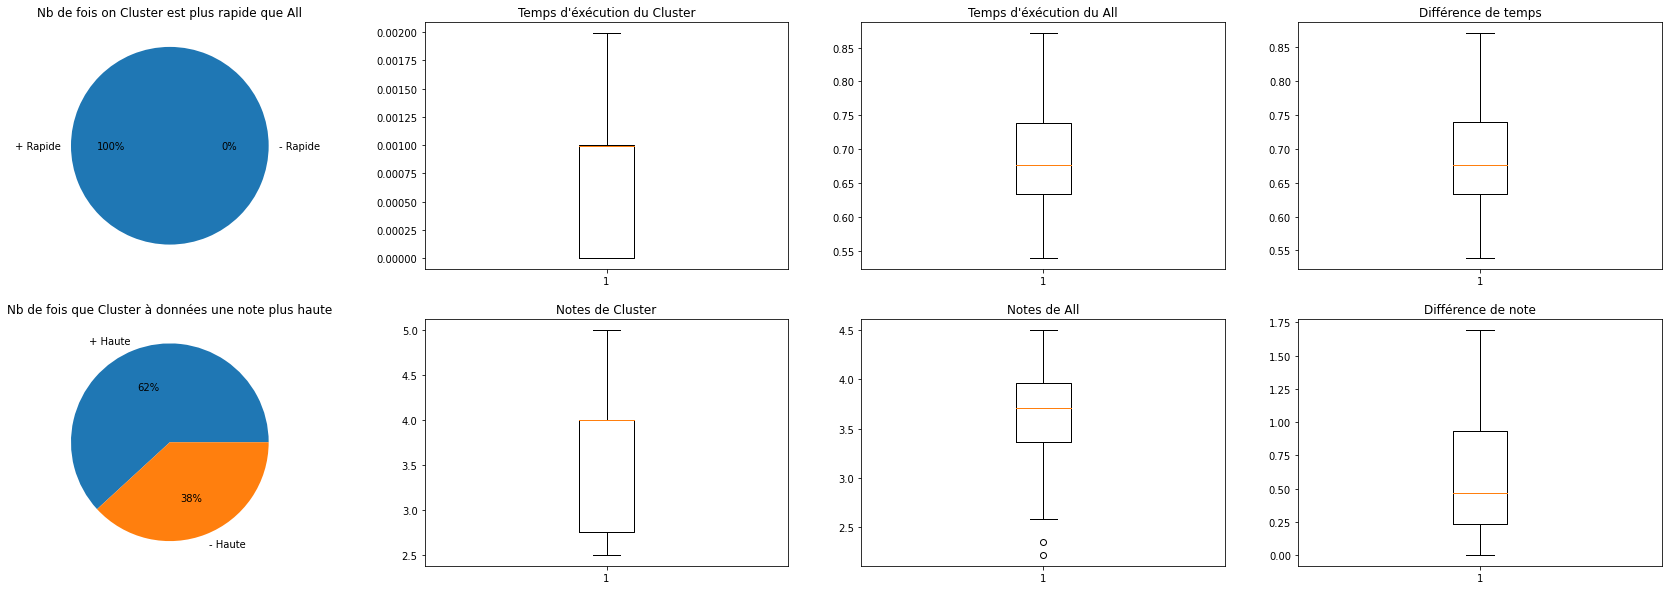

In [70]:
#On affiche graphiquement le comparatif
plt.figure(figsize=(30,10))

j = 0
plots_pie = [[positif, len(t1)-positif], [sup, len(n1)-sup]]
labels_pie = [["+ Rapide", "- Rapide"], ["+ Haute", "- Haute"]]
titles_pie = ["Nb de fois on Cluster est plus rapide que All", "Nb de fois que Cluster à données une note plus haute"]

k = 0
plots_box = [t1, t2, deltaT, n1, n2, deltaN]
titles_box = ["Temps d'éxécution du Cluster", "Temps d'éxécution du All", "Différence de temps", "Notes de Cluster", "Notes de All", "Différence de note"]

for i in range(8):
    plt.subplot(2, 4, i+1)

    if i+1 in [1, 5]:
        plt.pie(plots_pie[j], labels=labels_pie[j], autopct='%.0f%%')
        plt.title(titles_pie[j])
        j += 1
    else:
        plt.boxplot(plots_box[k])
        plt.title(titles_box[k])
        k += 1

plt.show()

In [114]:
c = [1] 
c += [1, 2]
c

[1, 1, 2]

In [116]:
users = userId_title_df.index[:10]

n_cluster = []
n_all = []
delta = []
n_true = []

for user in tqdm(users):
    all_rated_film = userId_title_df.loc[user].dropna(axis=0)
    n_true += all_rated_film.values.tolist()
    
    for movie in tqdm(all_rated_film.index):
        clust = guess_rate_cluster(user, movie)
        all = guess_rate_all(user, movie)

        delta.append(np.abs(all-clust))
        n_cluster.append(clust)
        n_all.append(all)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [123]:
n_cluster-n_true

TypeError: unsupported operand type(s) for -: 'list' and 'list'

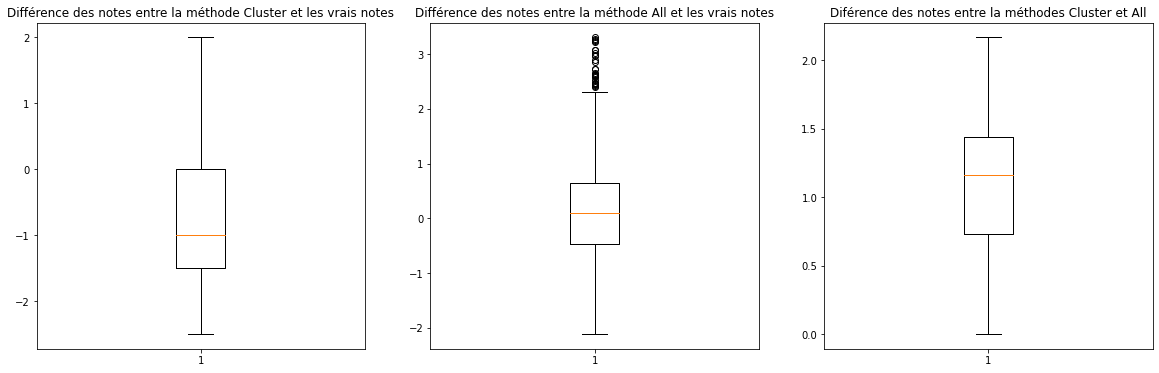

In [124]:
plt.figure(figsize=(20,6))

delta_cluster = []
delta_all = []
for i in range(len(n_true)):
    delta_cluster.append(n_cluster[i]-n_true[i])
    delta_all.append(n_all[i]-n_true[i])

plots = [delta_cluster, delta_all, delta]
titles = ["Différence des notes entre la méthode Cluster et les vrais notes", "Différence des notes entre la méthode All et les vrais notes", "Diférence des notes entre la méthodes Cluster et All"]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.boxplot(plots[i])
    plt.title(titles[i])

plt.show()